# 🏪 Store Sales Forecasting using Time Series & LightGBM

This notebook tackles the **Store Sales - Time Series Forecasting** competition on Kaggle.

We progressively build a forecasting model using:
- Time-based validation
- Lag features
- Rolling statistics
- Economic indicators (oil prices)
- Log-transformed target
- LightGBM

## 📖 Problem Statement

The goal of this competition is to predict store sales for a large Ecuadorian grocery retailer.

Challenges include:
- Multi-store multi-product forecasting
- Promotions affecting demand
- Seasonal patterns (weekly & monthly)
- Economic impact (oil prices)

The evaluation metric is **RMSLE (Root Mean Squared Logarithmic Error)**.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [4]:
train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
train.shape

(3000888, 6)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])

In [9]:
train['date'].min(),train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

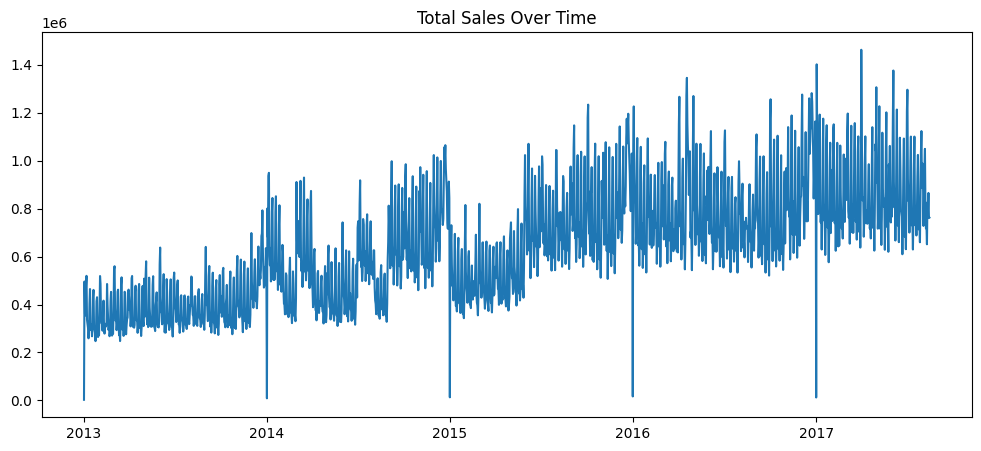

In [10]:
daily_sales=train.groupby('date')['sales'].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_sales)
plt.title('Total Sales Over Time')
plt.show()

In [11]:
train['year']=train['date'].dt.year
train['month']=train['date'].dt.month
train['day']=train['date'].dt.day
train['dayofweek']=train['date'].dt.dayofweek

test['year']=test['date'].dt.year
test['month']=test['date'].dt.month
test['day']=test['date'].dt.day
test['dayofweek']=test['date'].dt.dayofweek

In [12]:
from sklearn.preprocessing import LabelEncoder

le_family=LabelEncoder()
train['family']=le_family.fit_transform(train['family'])
test['family']=le_family.transform(test['family'])

In [13]:
features = ['store_nbr','family','onpromotion',
            'year','month','day','dayofweek']
x=train[features]
y=train['sales']
x_train,x_val,y_train,y_val=train_test_split(
    x,y,test_size=0.2,random_state=42
)
model=RandomForestRegressor(n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42)
model.fit(x_train,y_train)

preds=model.predict(x_val)

rmsle=np.sqrt(mean_squared_log_error(y_val,preds))
print('Baseline RMSLE:',rmsle)

Baseline RMSLE: 1.3939653858697885


In [14]:
split_date=train['date'].max()-pd.Timedelta(days=30)

train_data=train[train['date']<=split_date]
val_data=train[train['date']>split_date]

print('Train shape:',train_data.shape)
print('Validation Date:',val_data.shape)

Train shape: (2947428, 10)
Validation Date: (53460, 10)


In [15]:
train=train.sort_values(['store_nbr','family','date'])

train['lag_1']=train.groupby(['store_nbr','family'])['sales'].shift(1)
train['lag_7']=train.groupby(['store_nbr','family'])['sales'].shift(7)

train['rolling_mean_7']=(
    train.groupby(['store_nbr','family'])['sales']
    .shift(1)
    .rolling(7)
    .mean()
)
train=train.dropna()

In [16]:
features = [
    'store_nbr','family','onpromotion',
    'year','month','day','dayofweek',
    'lag_1','lag_7','rolling_mean_7'
]

In [17]:
split_date=train['date'].max()-pd.Timedelta(days=30)
train_data=train[train['date']<=split_date]
val_data=train[train['date']>split_date]
x_train=train_data[features]
y_train=train_data['sales']
x_val=val_data[features]
y_val=val_data['sales']

In [18]:
import lightgbm as lgb

model=lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)
model.fit(x_train, y_train)
preds = model.predict(x_val)

preds = np.clip(preds, 0, None)

from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error(y_val, preds))

print("Day 2 RMSLE:", rmsle)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 2934954, number of used features: 10
[LightGBM] [Info] Start training from score 356.432139
Day 2 RMSLE: 0.49391623808446866


In [19]:
train=train.sort_values(['store_nbr','family','date'])
lags=[1,7,14,28]

for lag in lags:
    train[f'lag_{lag}']=(
        train.groupby(['store_nbr','family'])['sales']
        .shift(lag)
    )
train['rolling_mean_7']=(
    train.groupby(['store_nbr','family'])['sales']
    .shift(1)
    .rolling(7)
    .mean()
)
train['rolling_std_7']=(
    train.groupby(['store_nbr','family'])['sales']
    .shift(7)
    .rolling(7)
    .std()
)
train=train.dropna()

In [20]:
oil=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
oil['date']=pd.to_datetime(oil['date'])

oil=oil.rename(columns={'dcoilwtico':'oil_price'})

train=train.merge(oil,on='date',how='left')
train['oil_price']=train['oil_price'].fillna(method='ffill')

In [21]:
features = [
    'store_nbr','family','onpromotion',
    'year','month','day','dayofweek',
    'oil_price',
    'lag_1','lag_7','lag_14','lag_28',
    'rolling_mean_7','rolling_std_7'
]

In [22]:
split_date=train['date'].max()-pd.Timedelta(days=30)

train_data=train[train['date']<=split_date]
val_data=train[train['date']>split_date]

x_train=train_data[features]
y_train=train_data['sales']

x_val=val_data[features]
y_val=val_data['sales']

In [23]:
model=lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train,y_train)
preds=model.predict(x_val)
preds=np.clip(preds,0,None)
rmsle=np.sqrt(mean_squared_log_error(y_val,preds))
print('Day 3 RMSLE:',rmsle)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 2885058, number of used features: 14
[LightGBM] [Info] Start training from score 359.304064
Day 3 RMSLE: 0.481549450539389


In [24]:
y_train_log = np.log1p(y_train)

In [25]:
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(x_train, y_train_log)
preds_log = model.predict(x_val)

preds = np.expm1(preds_log)

preds = np.clip(preds, 0, None)

rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
print("Improved RMSLE:", rmsle)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 2885058, number of used features: 14
[LightGBM] [Info] Start training from score 2.933045
Improved RMSLE: 0.38175365532257877


In [27]:
x_full=train[features]
y_full=np.log1p(train['sales'])

model=lgb.LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=225,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

In [30]:
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
test['date']=pd.to_datetime(test['date'])

In [31]:
test['year']=test['date'].dt.year
test['month']=test['date'].dt.month
test['day']=test['date'].dt.day
test['dayofweek']=test['date'].dt.dayofweek
test['is_weekend']=test['dayofweek'].isin([5,6]).astype(int)


In [32]:
test=test.merge(oil,on='date',how='left')
test['oil_price']=test['oil_price'].fillna(method='ffill')

In [37]:
train_full = train.copy()
test_full = test.copy()

train_full = train_full[['store_nbr','family','date','sales']]

test_full['sales'] = np.nan

combined = pd.concat([train_full, test_full], ignore_index=True)

combined = combined.sort_values(['store_nbr','family','date'])

predictions = []

for date in sorted(test_full['date'].unique()):
    
    for lag in [1,7,14,28]:
        combined[f'lag_{lag}'] = (
            combined.groupby(['store_nbr','family'])['sales']
            .shift(lag)
        )

    combined['rolling_mean_7'] = (
        combined.groupby(['store_nbr','family'])['sales']
        .shift(1)
        .rolling(7)
        .mean()
    )

    combined['rolling_std_7'] = (
        combined.groupby(['store_nbr','family'])['sales']
        .shift(1)
        .rolling(7)
        .std()
    )

    current_test = combined[combined['date'] == date].copy()

    X_test = current_test[features]

    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)
    preds = np.clip(preds, 0, None)

    combined.loc[current_test.index, 'sales'] = preds

    predictions.extend(preds)

NotFittedError: Estimator not fitted, call fit before exploiting the model.